In [1]:
%load_ext cython

In [2]:
import numpy as np
import random
import time
import json
import os
import requests
from typing import List, Dict, Tuple, Optional
import matplotlib.pyplot as plt
from collections import defaultdict

In [3]:
import numpy as np

def load_profits_from_file(filename, num_objectives, num_items):
    profits = np.zeros((num_objectives, num_items))
    with open(filename, 'r') as f:
        lines = [line.strip() for line in f if line.strip()]
    idx = 0
    idx += 1  # skip header
    for obj in range(num_objectives):
        idx += 1  # skip capacity line
        for item in range(num_items):
            idx += 1  # skip "n:" line
            idx += 1  # skip weight
            profit = int(lines[idx])
            profits[obj, item] = profit
            idx += 1
    return profits

def load_weights_from_file(filename, num_objectives, num_items):
    weights = np.zeros((num_objectives, num_items), dtype=int)
    with open(filename, 'r') as f:
        lines = [line.strip() for line in f if line.strip()]
    idx = 0
    idx += 1  # skip header
    for obj in range(num_objectives):
        idx += 1  # skip capacity line
        for item in range(num_items):
            idx += 1  # skip "n:" line
            weight = int(lines[idx])
            weights[obj, item] = weight
            idx += 2  # skip profit
    return weights

def load_capacities_from_file(filename, num_objectives, num_items):
    with open(filename, 'r') as f:
        lines = [line.strip() for line in f if line.strip()]
    idx = 0
    idx += 1  # skip header
    capacities = []
    for obj in range(num_objectives):
        cap = float(lines[idx])
        capacities.append(cap)
        idx += 1 + 3 * num_items
    return np.array(capacities)

In [4]:
# Setup Ollama Llama3
OLLAMA_URL = "http://localhost:11434/api/generate"
MODEL_NAME = "llama3"

def generate_llm_response(system_prompt, user_prompt, max_new_tokens=500):
    """Generate a response from Ollama Llama3 using the provided prompts."""
    prompt = f"System: {system_prompt}\n\nUser: {user_prompt}\n\nAssistant:"
    
    payload = {
        "model": MODEL_NAME,
        "prompt": prompt,
        "stream": False,
        "options": {
            "temperature": 0.6,
            "top_p": 0.9,
            "num_predict": max_new_tokens
        }
    }
    
    try:
        response = requests.post(OLLAMA_URL, json=payload)
        response.raise_for_status()
        result = response.json()
        return result.get("response", "")
    except Exception as e:
        print(f"Error generating LLM response: {e}")
        return "def mock_function():\n    pass"

def extract_code_from_response(response):
    """Extract Python code from LLM response with improved parsing."""
    markers = [
        ("```python", "```"),
        ("```Python", "```"),
        ("```", "```"),
        ("`", "`")
    ]
    
    for start_marker, end_marker in markers:
        start_idx = response.find(start_marker)
        if start_idx != -1:
            start_idx += len(start_marker)
            end_idx = response.find(end_marker, start_idx)
            if end_idx != -1:
                return response[start_idx:end_idx].strip()
    
    # Fallback: Look for function definitions
    lines = response.split('\n')
    code_lines = []
    in_function = False
    
    for line in lines:
        if line.strip().startswith('def '):
            in_function = True
            code_lines.append(line)
        elif in_function:
            if line.strip() and not line.startswith(' ') and not line.startswith('\t'):
                break
            code_lines.append(line)
    
    if code_lines:
        return '\n'.join(code_lines)
    
    return response.strip()

In [5]:
class MHREFunctionGenerator:
    """Enhanced function generator with proper MHRE hierarchical evolution."""
    
    def __init__(self):
        self.sub_functions = defaultdict(list)  # Sub-functions by type
        self.architecture_functions = []  # Architecture functions
        self.generation_count = 0
        self.max_generations = 10  # Reduced for performance
        self.validation_cache = {}
        self.performance_history = defaultdict(list)
        self.evolution_stats = {
            'crossover_evolution': 0,
            'cooperative_evolution': 0,
            'architecture_upgrade': 0,
            'successful_evolutions': 0
        }
        # Performance optimization: pre-compile templates
        self.function_templates = self._create_function_templates()
        
    def _create_function_templates(self):
        """Create optimized function templates for faster generation."""
        templates = {
            "mutation": """
def mutation_move(observation, profits, weights, capacities, archive_objs=None, best_observation=None):
    try:
        obs_list = observation.tolist() if hasattr(observation, 'tolist') else list(observation)
        selected = [i for i, val in enumerate(obs_list) if val == 1]
        unselected = [i for i, val in enumerate(obs_list) if val == 0]
        
        if not selected or not unselected:
            return 0, 0
        
        # Enhanced mutation with adaptive probability
        mutation_strength = 0.1 + 0.3 * np.random.random()
        if np.random.random() < mutation_strength:
            remove_idx = int(np.random.choice(selected))
            add_idx = int(np.random.choice(unselected))
        else:
            # Bias towards less used items
            remove_idx = selected[np.random.randint(len(selected))]
            add_idx = unselected[np.random.randint(len(unselected))]
        
        return remove_idx, add_idx
    except Exception:
        return 0, 0
""",
            "local_search": """
def local_search_move(observation, profits, weights, capacities, archive_objs=None, best_observation=None):
    try:
        obs_list = observation.tolist() if hasattr(observation, 'tolist') else list(observation)
        selected = [i for i, val in enumerate(obs_list) if val == 1]
        unselected = [i for i, val in enumerate(obs_list) if val == 0]
        
        if not selected or not unselected or profits is None:
            return 0, 0
        
        # Enhanced local search with weighted objectives
        selected_profits = []
        unselected_profits = []
        
        for idx in selected:
            total_profit = sum(profits[f, idx] * (1.0 + 0.1 * f) for f in range(profits.shape[0]))
            selected_profits.append(total_profit)
        
        for idx in unselected:
            total_profit = sum(profits[f, idx] * (1.0 + 0.1 * f) for f in range(profits.shape[0]))
            unselected_profits.append(total_profit)
        
        # Add small random factor to avoid deterministic behavior
        selected_profits = np.array(selected_profits) + np.random.normal(0, 0.01, len(selected_profits))
        unselected_profits = np.array(unselected_profits) + np.random.normal(0, 0.01, len(unselected_profits))
        
        remove_idx = selected[np.argmin(selected_profits)]
        add_idx = unselected[np.argmax(unselected_profits)]
        
        return int(remove_idx), int(add_idx)
    except Exception:
        return 0, 0
""",
            "architecture": """
def enhanced_arch_function(move_types, move_counts, move_successes, move_probs, smoothing):
    try:
        epsilon = 1e-9
        rates = np.array([move_successes[k]/(move_counts[k] + epsilon) for k in move_types], dtype=np.float64)
        
        # Multi-objective architecture consideration
        # Balance exploration vs exploitation based on success rates
        exploration_factor = 1.0 - np.mean(rates)
        exploitation_factor = np.max(rates)
        
        # Adaptive smoothing based on performance diversity
        adaptive_smoothing = smoothing * (1.0 + 0.5 * np.std(rates))
        
        # Enhanced probability calculation
        exp_rates = np.exp(rates / (adaptive_smoothing + epsilon))
        diversity_bonus = 1.0 / (np.array([move_counts[k] for k in move_types]) + epsilon)
        
        combined_scores = exp_rates * (1.0 + 0.1 * diversity_bonus)
        new_probs = combined_scores / (np.sum(combined_scores) + epsilon)
        
        # Hierarchical update with momentum
        momentum = 0.3 + 0.4 * exploration_factor
        updated_move_probs = momentum * move_probs + (1.0 - momentum) * new_probs
        updated_move_probs = updated_move_probs / (np.sum(updated_move_probs) + epsilon)
        
        return updated_move_probs
    except Exception as e:
        return move_probs / np.sum(move_probs)
"""
        }
        return templates
    
    def pre_generate_functions(self):
        """Pre-generate functions using templates for better performance."""
        move_types = ["mutation", "local_search", "global_search", "follow", "diversity"]
        success_count = 0
        
        print("Pre-generating MHRE functions with templates...")
        
        for move_type in move_types:
            # Use template if available, otherwise generate
            if move_type in self.function_templates:
                code = self.function_templates[move_type]
                is_valid = self._quick_validate_template(code, move_type)
            else:
                code = self.generate_sub_function_with_llm(move_type)
                is_valid, _ = self.validate_function(code, f"{move_type}_move", 
                                                   [('array', 250), ('array_2d', (2, 250)), ('array_2d', (2, 250)), ('array', 2), None, None])
            
            if is_valid:
                self.sub_functions[move_type].append({
                    'code': code,
                    'generation': 0,
                    'performance': 0.0,
                    'usage_count': 0,
                    'template_based': move_type in self.function_templates
                })
                success_count += 1
        
        # Pre-generate architecture function
        arch_code = self.function_templates["architecture"]
        if self._quick_validate_template(arch_code, "architecture"):
            self.architecture_functions.append({
                'code': arch_code,
                'generation': 0,
                'performance': 0.0,
                'usage_count': 0,
                'template_based': True
            })
            success_count += 1
        
        print(f"Successfully pre-generated {success_count} functions (template-based optimization)")
        return success_count > 0
    
    def _quick_validate_template(self, code, function_type):
        """Quick validation for template-based functions."""
        try:
            namespace = {'np': np}
            exec(code, namespace)
            if function_type == "architecture":
                return "enhanced_arch_function" in namespace
            else:
                return f"{function_type}_move" in namespace
        except:
            return False
    
    def generate_sub_function_with_llm(self, function_type):
        """Generate sub-function using LLM with caching."""
        if self.generation_count >= self.max_generations:
            return None
        
        cache_key = f"sub_{function_type}_{self.generation_count}"
        if cache_key in self.validation_cache:
            return self.validation_cache[cache_key]
        
        system_prompt = f"""You are an expert in multi-objective optimization heuristics.
        Generate a {function_type} move function for multi-objective knapsack problems.
        Focus on: 1) Integer operations 2) Edge case handling 3) Multi-objective awareness 4) Performance
        Return only Python code."""
        
        user_prompt = f"""Create a {function_type}_move function with signature:
        def {function_type}_move(observation, profits, weights, capacities, archive_objs=None, best_observation=None):
            # Your implementation
            return remove_idx, add_idx
        
        Requirements:
        - observation: binary array (0/1)
        - profits: 2D array [objectives, items]  
        - Return two integers
        - Handle edge cases
        - Consider multi-objective nature
        
        {self._get_function_description(function_type)}"""
        
        try:
            response = generate_llm_response(system_prompt, user_prompt, max_new_tokens=300)
            code = extract_code_from_response(response)
            self.generation_count += 1
            self.validation_cache[cache_key] = code
            return code
        except Exception as e:
            print(f"Error generating {function_type}: {e}")
            return None
    
    def crossover_evolution(self, parent1, parent2, function_type):
        """Hierarchical crossover evolution between sub-functions."""
        self.evolution_stats['crossover_evolution'] += 1
        
        # Performance-based crossover
        if parent1['performance'] > parent2['performance']:
            dominant_parent = parent1
            recessive_parent = parent2
        else:
            dominant_parent = parent2
            recessive_parent = parent1
        
        system_prompt = """Create improved function by combining two parent functions.
        Favor the better-performing parent while incorporating useful features from the other.
        Maintain multi-objective optimization focus."""
        
        user_prompt = f"""Combine these {function_type} functions:
        
        Dominant Parent (performance: {dominant_parent['performance']:.3f}):
        ```python
        {dominant_parent['code']}
        ```
        
        Recessive Parent (performance: {recessive_parent['performance']:.3f}):
        ```python
        {recessive_parent['code']}
        ```
        
        Create a child function that:
        1. Inherits main logic from dominant parent
        2. Incorporates beneficial features from recessive parent
        3. Adds small improvements for multi-objective optimization
        
        Return only the Python code."""
        
        try:
            response = generate_llm_response(system_prompt, user_prompt, max_new_tokens=400)
            code = extract_code_from_response(response)
            
            # Quick validation
            if self._quick_validate_template(code, function_type):
                child = {
                    'code': code,
                    'generation': self.generation_count,
                    'performance': 0.0,
                    'usage_count': 0,
                    'parents': [dominant_parent['generation'], recessive_parent['generation']]
                }
                self.generation_count += 1
                self.evolution_stats['successful_evolutions'] += 1
                return child
            else:
                return dominant_parent
        except Exception as e:
            print(f"Crossover evolution failed: {e}")
            return dominant_parent
    
    def cooperative_evolution(self, sub_function, arch_function):
        """Cooperative evolution between sub-functions and architecture functions."""
        self.evolution_stats['cooperative_evolution'] += 1
        
        system_prompt = """Improve sub-function and architecture function to work better together.
        Focus on their interaction and complementary strengths."""
        
        user_prompt = f"""Improve these functions for better cooperation:
        
        Sub-function:
        ```python
        {sub_function['code']}
        ```
        
        Architecture function:
        ```python
        {arch_function['code']}
        ```
        
        Create improved versions that:
        1. Better coordinate between move selection and architecture decisions
        2. Share information more effectively
        3. Adapt to multi-objective optimization challenges
        
        Return both improved functions clearly separated."""
        
        try:
            response = generate_llm_response(system_prompt, user_prompt, max_new_tokens=600)
            
            # Extract both functions (simplified approach)
            if "def " in response and response.count("def ") >= 2:
                # Try to extract both functions
                lines = response.split('\n')
                sub_code_lines = []
                arch_code_lines = []
                current_function = None
                
                for line in lines:
                    if line.strip().startswith('def ') and '_move(' in line:
                        current_function = 'sub'
                        sub_code_lines.append(line)
                    elif line.strip().startswith('def ') and 'arch' in line.lower():
                        current_function = 'arch'
                        arch_code_lines.append(line)
                    elif current_function == 'sub':
                        sub_code_lines.append(line)
                    elif current_function == 'arch':
                        arch_code_lines.append(line)
                
                if sub_code_lines and arch_code_lines:
                    new_sub_code = '\n'.join(sub_code_lines)
                    new_arch_code = '\n'.join(arch_code_lines)
                    
                    # Validate both
                    sub_valid = self._quick_validate_template(new_sub_code, "sub")
                    arch_valid = self._quick_validate_template(new_arch_code, "architecture")
                    
                    if sub_valid and arch_valid:
                        new_sub_function = {
                            'code': new_sub_code,
                            'generation': self.generation_count,
                            'performance': 0.0,
                            'usage_count': 0,
                            'cooperative_evolution': True
                        }
                        
                        new_arch_function = {
                            'code': new_arch_code,
                            'generation': self.generation_count,
                            'performance': 0.0,
                            'usage_count': 0,
                            'cooperative_evolution': True
                        }
                        
                        self.generation_count += 1
                        self.evolution_stats['successful_evolutions'] += 1
                        return new_sub_function, new_arch_function
            
            # Fallback to original functions
            return sub_function, arch_function
        except Exception as e:
            print(f"Cooperative evolution failed: {e}")
            return sub_function, arch_function
    
    def architecture_upgrade(self, arch_function, performance_feedback):
        """Hierarchical architecture upgrade based on performance feedback."""
        self.evolution_stats['architecture_upgrade'] += 1
        
        system_prompt = """Upgrade architecture function based on performance feedback.
        Focus on improving decision-making and adaptation mechanisms."""
        
        user_prompt = f"""Upgrade this architecture function:
        
        Current function:
        ```python
        {arch_function['code']}
        ```
        
        Performance feedback: {performance_feedback}
        Current performance: {arch_function['performance']:.3f}
        
        Improvements needed:
        1. Better adaptation to multi-objective challenges
        2. More robust probability updates
        3. Enhanced exploration-exploitation balance
        
        Return only the upgraded Python code."""
        
        try:
            response = generate_llm_response(system_prompt, user_prompt, max_new_tokens=400)
            code = extract_code_from_response(response)
            
            if self._quick_validate_template(code, "architecture"):
                upgraded_function = {
                    'code': code,
                    'generation': self.generation_count,
                    'performance': 0.0,
                    'usage_count': 0,
                    'upgraded': True
                }
                self.generation_count += 1
                self.evolution_stats['successful_evolutions'] += 1
                return upgraded_function
            else:
                return arch_function
        except Exception as e:
            print(f"Architecture upgrade failed: {e}")
            return arch_function
    
    def get_best_function(self, function_type):
        """Get best performing function with usage balancing."""
        if function_type not in self.sub_functions or not self.sub_functions[function_type]:
            return None
        
        functions = self.sub_functions[function_type]
        
        # Balance performance vs exploration
        best_score = -float('inf')
        best_function = None
        
        for func in functions:
            # Score combines performance and exploration bonus
            exploration_bonus = 1.0 / (func['usage_count'] + 1)
            score = func['performance'] + 0.1 * exploration_bonus
            
            if score > best_score:
                best_score = score
                best_function = func
        
        return best_function
    
    def update_function_performance(self, function_type, function_idx, performance_delta):
        """Update function performance with decay."""
        if function_type in self.sub_functions and function_idx < len(self.sub_functions[function_type]):
            func = self.sub_functions[function_type][function_idx]
            # Apply decay to old performance and add new delta
            func['performance'] = 0.9 * func['performance'] + performance_delta
            func['usage_count'] += 1
            self.performance_history[function_type].append(performance_delta)
    
    def get_evolution_stats(self):
        """Get evolution statistics."""
        return self.evolution_stats.copy()
    
    def _get_function_description(self, function_type):
        """Get function descriptions."""
        descriptions = {
            "mutation": "Random exploration with adaptive strength",
            "local_search": "Greedy improvement with multi-objective weighting", 
            "global_search": "Probability-based selection with diversity",
            "follow": "Mimic successful solutions with variation",
            "diversity": "Maximize distance from archive solutions"
        }
        return descriptions.get(function_type, "Implement optimization strategy")
    
    # Add validation method (keep as is but optimize)
    def validate_function(self, code, function_name, input_args):
        """Optimized validation with caching."""
        cache_key = f"{function_name}_{hash(code)}"
        if cache_key in self.validation_cache:
            return self.validation_cache[cache_key]
        
        try:
            namespace = {'np': np}
            exec(code, namespace)
            
            if function_name not in namespace:
                result = (False, f"Function '{function_name}' not found")
                self.validation_cache[cache_key] = result
                return result
            
            # Quick validation without full execution
            self.validation_cache[cache_key] = (True, "Valid")
            return (True, "Valid")
        except Exception as e:
            result = (False, f"Validation error: {str(e)}")
            self.validation_cache[cache_key] = result
            return result

In [6]:
class MHREAgentArchitecture:
    """Enhanced architecture with proper MHRE hierarchical structure."""
    
    def __init__(self, move_types, smoothing=0.1, llm_generator=None):
        self.move_types = list(move_types)
        self.move_counts = {k: 1 for k in self.move_types}
        self.move_successes = {k: 1 for k in self.move_types}
        self.move_probs = np.ones(len(self.move_types)) / len(self.move_types)
        self.smoothing = smoothing
        self.llm_generator = llm_generator
        self.performance_history = []
        self.upgrade_count = 0
        self.reflection_count = 0
        
        # Enhanced architecture function with better default
        self.architecture_function = {
            'code': """
def enhanced_arch_function(move_types, move_counts, move_successes, move_probs, smoothing):
    try:
        epsilon = 1e-9
        rates = np.array([move_successes[k]/(move_counts[k] + epsilon) for k in move_types], dtype=np.float64)
        
        # Multi-objective architecture considerations
        exploration_factor = 1.0 - np.mean(rates)
        adaptive_smoothing = smoothing * (1.0 + 0.5 * np.std(rates))
        
        # Enhanced probability calculation
        exp_rates = np.exp(rates / (adaptive_smoothing + epsilon))
        diversity_bonus = 1.0 / (np.array([move_counts[k] for k in move_types]) + epsilon)
        
        combined_scores = exp_rates * (1.0 + 0.1 * diversity_bonus)
        new_probs = combined_scores / (np.sum(combined_scores) + epsilon)
        
        # Hierarchical update with momentum
        momentum = 0.3 + 0.4 * exploration_factor
        updated_move_probs = momentum * move_probs + (1.0 - momentum) * new_probs
        updated_move_probs = updated_move_probs / (np.sum(updated_move_probs) + epsilon)
        
        return updated_move_probs
    except Exception:
        return move_probs / np.sum(move_probs)
""",
            'generation': 0,
            'performance': 0.0,
            'usage_count': 0
        }
    
    def select_move(self):
        """Select move with epsilon-greedy exploration."""
        epsilon = 0.1  # Small exploration probability
        if np.random.random() < epsilon:
            return np.random.choice(self.move_types)
        
        idx = np.random.choice(len(self.move_types), p=self.move_probs)
        return self.move_types[idx]
    
    def report_move_result(self, move_type, success):
        """Report move result with enhanced tracking."""
        if move_type not in self.move_types:
            return
        
        self.move_counts[move_type] += 1
        if success:
            self.move_successes[move_type] += 1
        
        # Use architecture function to update probabilities
        try:
            namespace = {'np': np}
            exec(self.architecture_function['code'], namespace)
            arch_func = namespace['enhanced_arch_function']
            
            self.move_probs = arch_func(
                self.move_types, 
                self.move_counts, 
                self.move_successes, 
                self.move_probs, 
                self.smoothing
            )
            
            # Track performance
            success_rate = self.move_successes[move_type] / self.move_counts[move_type]
            self.performance_history.append({
                'move_type': move_type,
                'success': success,
                'success_rate': success_rate,
                'timestamp': time.time()
            })
            
        except Exception as e:
            print(f"Architecture function error: {e}")
            # Fallback update
            self._fallback_update()
    
    def _fallback_update(self):
        """Fallback probability update."""
        epsilon = 1e-9
        rates = np.array([self.move_successes[k]/(self.move_counts[k] + epsilon) for k in self.move_types])
        exp_rates = np.exp(rates / self.smoothing)
        new_probs = exp_rates / np.sum(exp_rates)
        self.move_probs = 0.5 * self.move_probs + 0.5 * new_probs
        self.move_probs = self.move_probs / np.sum(self.move_probs)
    
    def reflect_and_upgrade(self):
        """Enhanced hierarchical reflection and upgrade."""
        if not self.llm_generator or len(self.performance_history) < 10:
            return False
        
        self.reflection_count += 1
        
        # Performance analysis
        recent_history = self.performance_history[-20:]  # Last 20 moves
        move_performance = {}
        
        for move_type in self.move_types:
            moves = [p for p in recent_history if p['move_type'] == move_type]
            if moves:
                success_rate = sum(1 for p in moves if p['success']) / len(moves)
                move_performance[move_type] = success_rate
        
        # Generate focused feedback
        best_move = max(move_performance, key=move_performance.get) if move_performance else 'unknown'
        worst_move = min(move_performance, key=move_performance.get) if move_performance else 'unknown'
        
        feedback = f"""
        Performance Analysis:
        - Best performing move: {best_move} ({move_performance.get(best_move, 0):.3f} success rate)
        - Worst performing move: {worst_move} ({move_performance.get(worst_move, 0):.3f} success rate)
        - Current probabilities: {dict(zip(self.move_types, self.move_probs))}
        - Upgrade count: {self.upgrade_count}
        
        Focus on improving probability adaptation and exploration-exploitation balance.
        """
        
        try:
            # Architecture upgrade with caching
            cache_key = f"arch_upgrade_{self.upgrade_count}_{hash(str(move_performance))}"
            
            self.architecture_function = self.llm_generator.architecture_upgrade(
                self.architecture_function, 
                feedback
            )
            
            self.upgrade_count += 1
            return True
        except Exception as e:
            print(f"Architecture upgrade failed: {e}")
            return False
    
    # Keep other methods as is (clone, mutate, get_performance_summary)
    def clone(self):
        """Create a clone of this architecture."""
        arch = MHREAgentArchitecture(self.move_types, self.smoothing, self.llm_generator)
        arch.move_counts = dict(self.move_counts)
        arch.move_successes = dict(self.move_successes)
        arch.move_probs = np.copy(self.move_probs)
        arch.performance_history = list(self.performance_history)
        arch.architecture_function = self.architecture_function.copy()
        return arch
    
    def mutate(self, registry, mutation_rate=0.25):
        """Mutate the architecture by adding/removing move types."""
        move_types = set(self.move_types)
        all_types = set(registry.keys())
        
        if random.random() < mutation_rate and len(move_types) < len(all_types):
            add = random.choice(list(all_types - move_types))
            move_types.add(add)
        
        if random.random() < mutation_rate and len(move_types) > 1:
            drop = random.choice(list(move_types))
            move_types.remove(drop)
        
        self.move_types = list(move_types)
        random.shuffle(self.move_types)
        
        # Reset counts for new move types
        self.move_counts = {k: 1 for k in self.move_types}
        self.move_successes = {k: 1 for k in self.move_types}
        self.move_probs = np.ones(len(self.move_types)) / len(self.move_types)
    
    def get_performance_summary(self):
        """Get a summary of the architecture's performance."""
        if not self.performance_history:
            return {}
        
        move_stats = {}
        for move_type in self.move_types:
            moves = [p for p in self.performance_history if p['move_type'] == move_type]
            if moves:
                success_rate = sum(1 for p in moves if p['success']) / len(moves)
                usage_count = self.move_counts[move_type]
                move_stats[move_type] = {
                    'success_rate': success_rate,
                    'usage_count': usage_count,
                    'probability': self.move_probs[self.move_types.index(move_type)]
                }
        
        return {
            'move_stats': move_stats,
            'upgrade_count': self.upgrade_count,
            'reflection_count': self.reflection_count,
            'total_moves': len(self.performance_history)
        }

In [7]:
class MHREModularMetaAgent:
    """Enhanced modular agent with MHRE integration."""
    
    def __init__(self, num_items, num_objectives, profits, weights, capacities, 
                 move_types=None, smoothing=0.1, llm_generator=None):
        self.num_items = num_items
        self.num_objectives = num_objectives
        self.profits = profits
        self.weights = weights
        self.capacities = capacities
        self.llm_generator = llm_generator
        self.custom_moves = {}  # Store custom move functions
        self.evolution_count = 0
        self.performance_history = []
        self.total_moves = 0
        self.successful_moves = 0
        
        self.architecture = MHREAgentArchitecture(
            move_types if move_types else list(MOVE_REGISTRY.keys()), 
            smoothing=smoothing,
            llm_generator=llm_generator
        )
        
        self.best_observation = None
        self.last_move_type = None
        self.last_function_used = None
    
    def observe(self, state):
        """Observe the current state."""
        return np.array(state["Items"], dtype=np.int32)
    
    def act(self, observation, context=None):
        """Select and execute a move using MHRE principles."""
        archive_objs = context.get("archive_objs") if context else None
        best_obs = self.best_observation
        
        for attempt in range(3):  # Try up to 3 times
            move_type = self.architecture.select_move()
            
            # Get the best function for this move type
            if self.llm_generator:
                best_function = self.llm_generator.get_best_function(move_type)
                if best_function:
                    # Use the LLM-generated function
                    try:
                        namespace = {}
                        exec(best_function['code'], namespace)
                        move_fn = namespace[f"{move_type}_move"]
                        self.last_function_used = {
                            'type': move_type,
                            'generation': best_function['generation'],
                            'performance': best_function['performance']
                        }
                    except Exception as e:
                        print(f"Error executing LLM function: {e}")
                        move_fn = MOVE_REGISTRY.get(move_type, mutation_move)
                else:
                    # Fall back to predefined function
                    move_fn = MOVE_REGISTRY.get(move_type, mutation_move)
            else:
                # Use predefined function
                move_fn = MOVE_REGISTRY.get(move_type, mutation_move)
            
            try:
                move = move_fn(
                    observation, self.profits, self.weights, self.capacities,
                    archive_objs=archive_objs, best_observation=best_obs
                )
                
                if self._is_feasible(observation, move):
                    self.last_move_type = move_type
                    self.total_moves += 1
                    return move
            except Exception as e:
                print(f"Error executing move {move_type}: {str(e)}")
        
        # Fallback to mutation
        move = mutation_move(observation, self.profits, self.weights, self.capacities)
        self.last_move_type = "mutation"
        self.total_moves += 1
        return move
    
    def report_move_result(self, move_type, success):
        """Report the result of a move and update performance."""
        if move_type is None:
            move_type = self.last_move_type
        
        self.architecture.report_move_result(move_type, success)
        
        if success:
            self.successful_moves += 1
        
        # Update function performance if LLM function was used
        if self.llm_generator and self.last_function_used:
            function_type = self.last_function_used['type']
            if function_type in self.llm_generator.function_pool:
                # Find the function in the pool
                for i, func in enumerate(self.llm_generator.function_pool[function_type]):
                    if func['generation'] == self.last_function_used['generation']:
                        # Update performance
                        performance_delta = 1.0 if success else -0.5
                        self.llm_generator.update_function_performance(
                            function_type, i, performance_delta
                        )
                        break
        
        self.performance_history.append({
            'move_type': move_type,
            'success': success,
            'timestamp': time.time(),
            'total_moves': self.total_moves,
            'successful_moves': self.successful_moves
        })
    
    def update_best(self, observation):
        """Update the best observation seen so far."""
        self.best_observation = observation.copy()
    
    def _is_feasible(self, observation, move):
        """Check if a move is feasible."""
        if self.weights is None or self.capacities is None or move is None:
            return True
        
        remove_idx, add_idx = move
        if remove_idx == add_idx:
            return False
        
        items = observation.copy()
        if items[remove_idx] == 0 or items[add_idx] == 1:
            return False
        
        items[remove_idx] = 0
        items[add_idx] = 1
        total_weights = np.sum(self.weights * items, axis=1)
        feasible = np.all(total_weights <= self.capacities)
        return feasible
    
    def clone(self):
        """Create a clone of this agent."""
        agent = MHREModularMetaAgent(
            self.num_items, self.num_objectives, self.profits, self.weights, self.capacities,
            move_types=self.architecture.move_types,
            smoothing=self.architecture.smoothing,
            llm_generator=self.llm_generator
        )
        
        agent.architecture = self.architecture.clone()
        agent.custom_moves = dict(self.custom_moves)
        agent.evolution_count = self.evolution_count
        agent.total_moves = self.total_moves
        agent.successful_moves = self.successful_moves
        
        if self.best_observation is not None:
            agent.best_observation = self.best_observation.copy()
        
        return agent
    
    def mutate(self, registry, mutation_rate=0.25):
        """Mutate the agent's architecture."""
        self.architecture.mutate(registry, mutation_rate=mutation_rate)
    
    def evolve_with_llm(self, other_agent=None):
        """Evolve the agent using LLM-based evolution."""
        if not self.llm_generator or self.evolution_count >= 5:
            return False
        
        try:
            if other_agent:
                # Crossover evolution
                if random.random() < 0.5:
                    move_type = random.choice(self.architecture.move_types)
                    
                    # Get best functions from both agents
                    func1 = self.llm_generator.get_best_function(move_type)
                    func2 = self.llm_generator.get_best_function(move_type)
                    
                    if func1 and func2:
                        new_function = self.llm_generator.crossover_evolution(func1, func2, move_type)
                        
                        if new_function != func1:  # Evolution successful
                            self.llm_generator.function_pool[move_type].append(new_function)
                            self.evolution_count += 1
                            return True
                else:
                    # Cooperative evolution
                    if self.custom_moves:
                        move_type = random.choice(list(self.custom_moves.keys()))
                        
                        # Get sub-function and architecture function
                        sub_function = self.llm_generator.get_best_function(move_type)
                        arch_function = self.architecture.architecture_function
                        
                        if sub_function:
                            new_sub_function, new_arch_function = self.llm_generator.cooperative_evolution(
                                sub_function, arch_function
                            )
                            
                            if new_sub_function != sub_function:  # Evolution successful
                                self.llm_generator.function_pool[move_type].append(new_sub_function)
                                self.architecture.architecture_function = new_arch_function
                                self.evolution_count += 1
                                return True
            else:
                # Architecture upgrade
                if len(self.architecture.performance_history) >= 10:
                    if self.architecture.reflect_and_upgrade():
                        self.evolution_count += 1
                        return True
        except Exception as e:
            print(f"LLM evolution failed: {str(e)}")
        
        return False
    
    def get_performance_summary(self):
        """Get a summary of the agent's performance."""
        success_rate = self.successful_moves / self.total_moves if self.total_moves > 0 else 0
        
        return {
            'success_rate': success_rate,
            'total_moves': self.total_moves,
            'successful_moves': self.successful_moves,
            'evolution_count': self.evolution_count,
            'architecture_performance': self.architecture.get_performance_summary()
        }

In [8]:
class MHREAgentPopulationManager:
    """Enhanced population manager with optimized GSES cycle."""
    
    def __init__(self, num_agents, num_items, num_objectives, profits, weights, capacities, llm_generator=None):
        self.num_agents = num_agents
        self.llm_generator = llm_generator
        self.registry = MOVE_REGISTRY
        self.evolution_count = 0
        self.generation = 0
        self.performance_history = []
        self.gses_stats = {
            'generations': 0,
            'evolutions': 0,
            'upgrades': 0,
            'successful_evolutions': 0
        }
        
        # Performance optimization: reduce LLM calls
        self.evolution_frequency = 15  # Evolve every 15 generations
        self.last_evolution_gen = 0
        
        # Initialize agents with diverse configurations
        move_type_combinations = [
            ["mutation", "local_search"],
            ["local_search", "global_search"],
            ["global_search", "follow"],
            ["mutation", "diversity"],
            ["follow", "diversity", "mutation"]
        ]
        
        self.agents = []
        for i in range(num_agents):
            move_types = move_type_combinations[i % len(move_type_combinations)]
            agent = MHREModularMetaAgent(
                num_items, num_objectives, profits, weights, capacities,
                move_types=move_types,
                llm_generator=llm_generator
            )
            self.agents.append(agent)
        
        # Agent statistics
        self.agent_stats = [ 
            {"fitness_sum": 0.0, "moves": 0, "success_rate": 0.0, "fitness_history": []} 
            for _ in range(num_agents) 
        ]
    
    def select_agent_for_solution(self, solution_idx):
        """Select agent with performance-based probability."""
        if self.generation < 5:
            # Early generations: round-robin
            return self.agents[solution_idx % self.num_agents]
        
        # Later: performance-based selection
        performances = []
        for i, agent in enumerate(self.agents):
            stats = self.agent_stats[i]
            if stats["moves"] > 0:
                avg_fitness = stats["fitness_sum"] / stats["moves"]
                performances.append(avg_fitness)
            else:
                performances.append(0.0)
        
        # Softmax selection
        if max(performances) > 0:
            exp_perfs = np.exp(np.array(performances) / (max(performances) + 1e-9))
            probs = exp_perfs / np.sum(exp_perfs)
            selected_idx = np.random.choice(len(self.agents), p=probs)
        else:
            selected_idx = solution_idx % self.num_agents
        
        return self.agents[selected_idx]
    
    def report_agent_performance(self, agent_idx, solution_fitness):
        """Report agent performance with history tracking."""
        if agent_idx < len(self.agent_stats):
            stats = self.agent_stats[agent_idx]
            stats["fitness_sum"] += solution_fitness
            stats["moves"] += 1
            stats["fitness_history"].append(solution_fitness)
            
            # Keep history limited
            if len(stats["fitness_history"]) > 50:
                stats["fitness_history"] = stats["fitness_history"][-30:]
            
            # Update success rate
            agent = self.agents[agent_idx]
            if agent.total_moves > 0:
                stats["success_rate"] = agent.successful_moves / agent.total_moves
    
    def gses_agent_level(self):
        """Optimized GSES cycle with performance-based evolution."""
        self.gses_stats['generations'] += 1
        
        # Generation phase: Calculate fitness
        agent_fitness = []
        for i, stats in enumerate(self.agent_stats):
            if stats["moves"] > 0:
                # Use recent performance trend
                recent_fitness = stats["fitness_history"][-10:] if len(stats["fitness_history"]) >= 10 else stats["fitness_history"]
                if recent_fitness:
                    fitness = np.mean(recent_fitness)
                    trend = np.polyfit(range(len(recent_fitness)), recent_fitness, 1)[0] if len(recent_fitness) > 1 else 0
                    adjusted_fitness = fitness + 0.1 * trend  # Bonus for improving agents
                else:
                    adjusted_fitness = stats["fitness_sum"] / stats["moves"]
            else:
                adjusted_fitness = -1e9
            
            agent_fitness.append((adjusted_fitness, i))
        
        # Standardization phase: Sort and select
        agent_fitness.sort(reverse=True)
        
        # Selection phase: Keep top performers
        num_survivors = max(2, self.num_agents // 2)
        survivors = [self.agents[idx] for _, idx in agent_fitness[:num_survivors]]
        
        # Record performance for monitoring
        best_fitness = agent_fitness[0][0] if agent_fitness else 0
        avg_fitness = np.mean([f for f, _ in agent_fitness]) if agent_fitness else 0
        
        self.performance_history.append({
            'generation': self.generation,
            'best_fitness': best_fitness,
            'avg_fitness': avg_fitness,
            'num_survivors': len(survivors),
            'evolution_count': self.evolution_count
        })
        
        # Evaluation phase: Create new population
        new_agents = []
        while len(new_agents) + len(survivors) < self.num_agents:
            if random.random() < 0.7 and len(survivors) >= 2:
                # Crossover with potential LLM evolution
                parent1, parent2 = random.sample(survivors, 2)
                child = parent1.clone()
                
                # LLM evolution (less frequent for performance)
                should_evolve = (
                    self.llm_generator is not None and 
                    self.generation - self.last_evolution_gen >= self.evolution_frequency and
                    self.evolution_count < 8  # Limit total evolutions
                )
                
                if should_evolve and random.random() < 0.4:
                    if child.evolve_with_llm(parent2):
                        self.evolution_count += 1
                        self.gses_stats['evolutions'] += 1
                        self.gses_stats['successful_evolutions'] += 1
                        self.last_evolution_gen = self.generation
                
                child.mutate(self.registry, mutation_rate=0.25)
                new_agents.append(child)
            else:
                # Mutation
                parent = random.choice(survivors)
                child = parent.clone()
                child.mutate(self.registry, mutation_rate=0.5)
                new_agents.append(child)
        
        # Update population
        self.agents = survivors + new_agents
        
        # Reset statistics
        self.agent_stats = [ 
            {"fitness_sum": 0.0, "moves": 0, "success_rate": 0.0, "fitness_history": []} 
            for _ in range(self.num_agents) 
        ]
        
        self.generation += 1
        print(f"Generation {self.generation}: Best={best_fitness:.2f}, Avg={avg_fitness:.2f}, Evolutions={self.evolution_count}")
    
    def evolve_with_llm(self):
        """Perform targeted LLM evolution."""
        if not self.llm_generator or self.evolution_count >= 10:
            return
        
        # Focus on worst-performing agents
        performances = []
        for i, agent in enumerate(self.agents):
            stats = self.agent_stats[i]
            if stats["moves"] > 0:
                avg_fitness = stats["fitness_sum"] / stats["moves"]
                performances.append((avg_fitness, i, agent))
            else:
                performances.append((0.0, i, agent))
        
        performances.sort()  # Worst first
        
        # Evolve worst 30% of agents
        num_to_evolve = max(1, int(0.3 * len(performances)))
        
        for _, idx, agent in performances[:num_to_evolve]:
            if random.random() < 0.5:  # 50% chance to evolve each
                if agent.evolve_with_llm():
                    self.evolution_count += 1
                    self.gses_stats['evolutions'] += 1
                    
                # Architecture upgrades for poorly performing agents
                if random.random() < 0.3:
                    if agent.architecture.reflect_and_upgrade():
                        self.gses_stats['upgrades'] += 1
    
    def get_population_stats(self):
        """Get comprehensive population statistics."""
        if not self.agents:
            return {}
        
        total_moves = sum(agent.total_moves for agent in self.agents)
        successful_moves = sum(agent.successful_moves for agent in self.agents)
        overall_success_rate = successful_moves / total_moves if total_moves > 0 else 0
        
        # Performance distribution
        performances = []
        for i, stats in enumerate(self.agent_stats):
            if stats["moves"] > 0:
                performances.append(stats["fitness_sum"] / stats["moves"])
        
        performance_stats = {
            'mean_performance': np.mean(performances) if performances else 0,
            'std_performance': np.std(performances) if performances else 0,
            'best_performance': max(performances) if performances else 0
        }
        
        return {
            'generation': self.generation,
            'total_agents': len(self.agents),
            'evolution_count': self.evolution_count,
            'overall_success_rate': overall_success_rate,
            'total_moves': total_moves,
            'successful_moves': successful_moves,
            'gses_stats': self.gses_stats.copy(),
            'performance_stats': performance_stats,
            'llm_stats': self.llm_generator.get_evolution_stats() if self.llm_generator else {}
        }

In [9]:
def mutation_move(observation, profits, weights, capacities, archive_objs=None, best_observation=None):
    """Simple mutation move with proper error handling."""
    try:
        obs_list = observation.tolist() if hasattr(observation, 'tolist') else list(observation)
        selected = [i for i, val in enumerate(obs_list) if val == 1]
        unselected = [i for i, val in enumerate(obs_list) if val == 0]
        
        if not selected or not unselected:
            return 0, 0
        
        remove_idx = int(np.random.choice(selected))
        add_idx = int(np.random.choice(unselected))
        
        return remove_idx, add_idx
    except Exception:
        return 0, 0

def local_search_move(observation, profits, weights, capacities, archive_objs=None, best_observation=None):
    """Local search move with proper error handling."""
    try:
        obs_list = observation.tolist() if hasattr(observation, 'tolist') else list(observation)
        selected = [i for i, val in enumerate(obs_list) if val == 1]
        unselected = [i for i, val in enumerate(obs_list) if val == 0]
        
        if not selected or not unselected or profits is None:
            return 0, 0
        
        # Calculate total profit for each item
        profs_selected = []
        for idx in selected:
            total_profit = sum(profits[f, idx] for f in range(profits.shape[0]))
            profs_selected.append(total_profit)
        
        profs_unselected = []
        for idx in unselected:
            total_profit = sum(profits[f, idx] for f in range(profits.shape[0]))
            profs_unselected.append(total_profit)
        
        remove_idx = selected[np.argmin(profs_selected)]
        add_idx = unselected[np.argmax(profs_unselected)]
        
        return int(remove_idx), int(add_idx)
    except Exception:
        return 0, 0

def global_search_move(observation, profits, weights, capacities, archive_objs=None, best_observation=None):
    """Global search move with proper error handling."""
    try:
        obs_list = observation.tolist() if hasattr(observation, 'tolist') else list(observation)
        selected = [i for i, val in enumerate(obs_list) if val == 1]
        unselected = [i for i, val in enumerate(obs_list) if val == 0]
        
        if not selected or not unselected or profits is None:
            return 0, 0
        
        # Calculate total profit for each item
        profs_selected = []
        for idx in selected:
            total_profit = sum(profits[f, idx] for f in range(profits.shape[0]))
            profs_selected.append(total_profit + 1e-9)  # Avoid division by zero
        
        profs_unselected = []
        for idx in unselected:
            total_profit = sum(profits[f, idx] for f in range(profits.shape[0]))
            profs_unselected.append(total_profit + 1e-9)  # Avoid division by zero
        
        # Normalize to probabilities
        probs_selected = np.array(profs_selected) / np.sum(profs_selected)
        probs_unselected = np.array(profs_unselected) / np.sum(profs_unselected)
        
        remove_idx = np.random.choice(selected, p=probs_selected)
        add_idx = np.random.choice(unselected, p=probs_unselected)
        
        return int(remove_idx), int(add_idx)
    except Exception:
        return 0, 0

def follow_move(observation, profits, weights, capacities, archive_objs=None, best_observation=None):
    """Follow move with proper error handling."""
    try:
        if best_observation is None:
            return mutation_move(observation, profits, weights, capacities)
        
        obs_list = observation.tolist() if hasattr(observation, 'tolist') else list(observation)
        best_list = best_observation.tolist() if hasattr(best_observation, 'tolist') else list(best_observation)
        
        # Find items to add and remove
        add_candidates = []
        remove_candidates = []
        
        for i in range(len(obs_list)):
            if obs_list[i] == 0 and best_list[i] == 1:
                add_candidates.append(i)
            elif obs_list[i] == 1 and best_list[i] == 0:
                remove_candidates.append(i)
        
        if not add_candidates or not remove_candidates:
            return mutation_move(observation, profits, weights, capacities)
        
        add_idx = int(np.random.choice(add_candidates))
        remove_idx = int(np.random.choice(remove_candidates))
        
        return remove_idx, add_idx
    except Exception:
        return mutation_move(observation, profits, weights, capacities)

def diversity_move(observation, profits, weights, capacities, archive_objs=None, best_observation=None):
    """Diversity move with proper error handling."""
    try:
        obs_list = observation.tolist() if hasattr(observation, 'tolist') else list(observation)
        selected = [i for i, val in enumerate(obs_list) if val == 1]
        unselected = [i for i, val in enumerate(obs_list) if val == 0]
        
        if not selected or not unselected or archive_objs is None or profits is None:
            return 0, 0
        
        best_move = None
        best_min_dist = -np.inf
        
        # Try several random moves
        for _ in range(3):
            remove_idx = int(np.random.choice(selected))
            add_idx = int(np.random.choice(unselected))
            
            # Create candidate solution
            candidate = obs_list.copy()
            candidate[remove_idx] = 0
            candidate[add_idx] = 1
            
            # Calculate objective values
            candidate_objs = []
            for f in range(profits.shape[0]):
                obj_val = sum(profits[f, i] for i in range(len(candidate)) if candidate[i] == 1)
                candidate_objs.append(obj_val)
            
            # Calculate minimum distance to archive
            dists = []
            for archive_sol in archive_objs:
                dist = np.linalg.norm(np.array(candidate_objs) - np.array(archive_sol))
                dists.append(dist)
            
            min_dist = min(dists) if dists else 0
            
            if min_dist > best_min_dist:
                best_min_dist = min_dist
                best_move = (remove_idx, add_idx)
        
        return best_move if best_move is not None else (0, 0)
    except Exception:
        return 0, 0

# Registry for moves
MOVE_REGISTRY = {
    "mutation": mutation_move,
    "local_search": local_search_move,
    "global_search": global_search_move,
    "follow": follow_move,
    "diversity": diversity_move,
}

In [10]:
%%cython
from libc.stdlib cimport malloc, free, srand, rand
from libc.string cimport memset
from libc.math cimport exp
import numpy as np
cimport numpy as np
import time

# Global variables for MHRE integration
cdef public object py_agent_manager = None
cdef public object py_llm_generator = None
cdef public object move_stats = None

# Data structures
cdef struct ind:
    int nombr_nonpris
    int nombr
    int rank
    float fitnessbest
    float fitness
    int explored
    double *f
    double *capa
    double *v
    int *d
    int *Items

cdef struct pop:
    int size
    int maxsize
    ind **ind_array

# Global parameters
cdef int NBITEMS = 250
cdef int ni = 250
cdef int L = 5
cdef double LARGE = 10e50
cdef float smallValue = 0.0000001
cdef double kappa = 0.05
cdef int alpha = 10
cdef int paretoIni = 28000
cdef int nf = 2
cdef double *capacities = NULL
cdef int **weights = NULL
cdef int **profits = NULL
cdef double *vector_weight = NULL
cdef double max_bound = 0.0
cdef double **OBJ_Weights = NULL
cdef int nombreLIGNE = 0
cdef int nextLn = 0
cdef int inv = 0
cdef int OBJ_Weights_lines = 0

# Helper functions
def set_agent_manager(agent_manager):
    global py_agent_manager
    py_agent_manager = agent_manager

def set_llm_generator(llm_generator):
    global py_llm_generator
    py_llm_generator = llm_generator

def reset_move_stats():
    global move_stats
    move_stats = {
        "total_agent_calls": 0, 
        "move_type_counts": {}, 
        "total_time_agent": 0.0, 
        "total_time_loop": 0.0,
        "llm_moves": 0,
        "predefined_moves": 0
    }

def print_move_stats():
    print("\n=== MHRE MOVE PROFILE ===")
    print("Total agent calls:", move_stats["total_agent_calls"])
    print("Move type counts:", move_stats["move_type_counts"])
    print("LLM moves:", move_stats["llm_moves"])
    print("Predefined moves:", move_stats["predefined_moves"])
    print("Total agent time (sec):", move_stats["total_time_agent"])
    print("Total loop time (sec):", move_stats["total_time_loop"])
    if move_stats["total_agent_calls"] > 0:
        print("Avg agent call time (ms):", 1000.0 * move_stats["total_time_agent"] / move_stats["total_agent_calls"])

def seed(int x):
    srand(x)

cdef int irand(int range_val):
    return rand() % range_val

cdef void *chk_malloc(size_t size):
    cdef void *return_value = malloc(size)
    if return_value == NULL:
        raise MemoryError("Out of memory.")
    memset(return_value, 0, size)
    return return_value

# Population and individual management
cdef pop *create_pop(int maxsize, int nf):
    cdef int i
    cdef pop *pp = <pop *>chk_malloc(sizeof(pop))
    pp.size = 0
    pp.maxsize = maxsize
    pp.ind_array = <ind **>chk_malloc(maxsize * sizeof(void*))
    for i in range(maxsize):
        pp.ind_array[i] = NULL
    return pp

cdef ind *create_ind(int nf):
    cdef int i
    cdef ind *p_ind = <ind *>chk_malloc(sizeof(ind))
    p_ind.nombr_nonpris = 0
    p_ind.nombr = 0
    p_ind.rank = 0
    p_ind.fitnessbest = -1.0
    p_ind.fitness = -1.0
    p_ind.explored = 0
    p_ind.f = <double *>chk_malloc(nf * sizeof(double))
    p_ind.capa = <double *>chk_malloc(nf * sizeof(double))
    p_ind.v = <double *>chk_malloc(nf * sizeof(double))
    p_ind.d = <int *>chk_malloc(ni * sizeof(int))
    p_ind.Items = <int *>chk_malloc(ni * sizeof(int))
    for i in range(ni):
        p_ind.Items[i] = 0
        p_ind.d[i] = 0
    for i in range(nf):
        p_ind.f[i] = 0.0
        p_ind.capa[i] = 0.0
        p_ind.v[i] = 0.0
    return p_ind

cdef ind *ind_copy(ind *i):
    cdef ind *p_ind = create_ind(nf)
    cdef int k
    p_ind.nombr_nonpris = i.nombr_nonpris
    p_ind.nombr = i.nombr
    p_ind.rank = i.rank
    p_ind.fitnessbest = i.fitnessbest
    p_ind.fitness = i.fitness
    p_ind.explored = i.explored
    for k in range(nf):
        p_ind.f[k] = i.f[k]
        p_ind.v[k] = i.v[k]
        p_ind.capa[k] = i.capa[k]
    for k in range(ni):
        p_ind.d[k] = i.d[k]
        p_ind.Items[k] = i.Items[k]
    return p_ind

cdef void free_ind(ind *p_ind):
    if p_ind != NULL:
        free(p_ind.d)
        free(p_ind.f)
        free(p_ind.capa)
        free(p_ind.v)
        free(p_ind.Items)
        free(p_ind)

cdef void complete_free_pop(pop *pp):
    cdef int i
    if pp != NULL:
        if pp.ind_array != NULL:
            for i in range(pp.size):
                if pp.ind_array[i] != NULL:
                    free_ind(pp.ind_array[i])
                    pp.ind_array[i] = NULL
            free(pp.ind_array)
        free(pp)

# Problem loading
cdef void loadMOKP(char *filename):
    global nf, ni, capacities, weights, profits
    cdef int i, f
    with open(filename.decode(), "r") as source:
        _nf, _ni = [int(x) for x in source.readline().split()]
        nf = _nf
        ni = _ni
        capacities = <double *>chk_malloc(nf * sizeof(double))
        weights = <int **>chk_malloc(nf * sizeof(void*))
        profits = <int **>chk_malloc(nf * sizeof(void*))
        for f in range(nf):
            capacities[f] = float(source.readline().strip())
            weights[f] = <int *>chk_malloc(ni * sizeof(int))
            profits[f] = <int *>chk_malloc(ni * sizeof(int))
            for i in range(ni):
                source.readline()  # item index
                weights[f][i] = int(source.readline().strip())
                profits[f][i] = int(source.readline().strip())

cdef void read_weights_file(char *filename):
    global OBJ_Weights, nombreLIGNE, nf, OBJ_Weights_lines
    cdef int i, j, nlines
    with open(filename.decode(), "r") as f:
        lines = [line for line in f if line.strip()]
    nlines = len(lines)
    OBJ_Weights = <double **>chk_malloc(nf * sizeof(void*))
    for i in range(nf):
        OBJ_Weights[i] = <double *>chk_malloc(nlines * sizeof(double))
    for i, line in enumerate(lines):
        vals = line.strip().split()
        for j in range(nf):
            OBJ_Weights[j][i] = float(vals[j])
    nombreLIGNE = nlines - 1
    OBJ_Weights_lines = nlines

# Weight management
cdef void dynamic_weight_allpop():
    global vector_weight, OBJ_Weights, nombreLIGNE, nf, nextLn
    cdef int i
    if vector_weight == NULL:
        vector_weight = <double *>chk_malloc(nf * sizeof(double))
    for i in range(nf):
        vector_weight[i] = OBJ_Weights[i][nextLn]
    if nextLn == nombreLIGNE:
        nextLn = 0
    else:
        nextLn += 1

cdef void choose_weight():
    dynamic_weight_allpop()

# Initialization and evaluation
cdef void random_init_ind(ind *x):
    cdef int j, r, tmp
    for j in range(ni):
        x.d[j] = j
    for j in range(ni):
        r = irand(ni)
        tmp = x.d[r]
        x.d[r] = x.d[j]
        x.d[j] = tmp

cdef void evaluate(ind *x):
    cdef int j, l, k, faisable
    x.nombr = 0
    x.nombr_nonpris = 0
    for j in range(nf):
        x.capa[j] = 0.0
        x.f[j] = 0.0
    for j in range(ni):
        l = 0
        faisable = 1
        while l < nf and faisable == 1:
            if x.capa[l] + weights[l][x.d[j]] > capacities[l]:
                faisable = 0
            l += 1
        if faisable == 1:
            for k in range(nf):
                x.capa[k] += weights[k][x.d[j]]
                x.f[k] += profits[k][x.d[j]]
            x.Items[x.d[j]] = 1
            x.nombr += 1
        else:
            x.Items[x.d[j]] = 0
            x.nombr_nonpris += 1

cdef void P_init_pop(pop *SP, pop *Sarchive, int alpha):
    cdef int i, x, tmp, t
    t = max(alpha, Sarchive.size)
    cdef int* shuffle = <int *>chk_malloc(t * sizeof(int))
    for i in range(t):
        shuffle[i] = i
    for i in range(t):
        x = irand(alpha)
        tmp = shuffle[i]
        shuffle[i] = shuffle[x]
        shuffle[x] = tmp
    SP.size = alpha
    if Sarchive.size > alpha:
        for i in range(alpha):
            SP.ind_array[i] = ind_copy(Sarchive.ind_array[shuffle[i]])
    else:
        for i in range(alpha):
            if shuffle[i] < Sarchive.size:
                SP.ind_array[i] = ind_copy(Sarchive.ind_array[shuffle[i]])
            else:
                SP.ind_array[i] = create_ind(nf)
                random_init_ind(SP.ind_array[i])
                evaluate(SP.ind_array[i])
    free(shuffle)

# Pareto dominance and fitness
cdef int non_dominated(ind *p_ind_a, ind *p_ind_b):
    cdef int i
    cdef int a_is_good = -1
    cdef int equal = 1
    for i in range(nf):
        if p_ind_a.f[i] > p_ind_b.f[i]:
            a_is_good = 1
        if p_ind_a.f[i] != p_ind_b.f[i]:
            equal = 0
    if equal:
        return 0
    return a_is_good

cdef double calcAddEpsIndicator(ind *p_ind_a, ind *p_ind_b):
    global max_bound
    cdef int i
    cdef double eps
    cdef double temp_eps
    if max_bound == 0.0:
        max_bound = 1e-8
    eps = (p_ind_a.v[0]/max_bound)-(p_ind_b.v[0]/max_bound)
    for i in range(1, nf):
        temp_eps = (p_ind_a.v[i]/max_bound)-(p_ind_b.v[i]/max_bound)
        if temp_eps > eps:
            eps = temp_eps
    return eps

cdef void init_fitness(ind *x):
    x.fitness = 0.0

cdef void update_fitness(ind *x, double I):
    x.fitness -= exp(-I / kappa)

cdef double update_fitness_return(double f, double I):
    return f - exp(-I / kappa)

cdef int delete_fitness(ind *x, double I):
    x.fitness += exp(-I / kappa)
    return 0

cdef void compute_ind_fitness(ind *x, pop *SP):
    cdef int j
    init_fitness(x)
    for j in range(SP.size):
        if SP.ind_array[j] != x:
            update_fitness(x, calcAddEpsIndicator(SP.ind_array[j], x))

cdef void compute_all_fitness(pop *SP):
    cdef int i
    for i in range(SP.size):
        compute_ind_fitness(SP.ind_array[i], SP)

# Archive extraction
cdef int extractPtoArchive(pop *P, pop *archive):
    cdef int i, j, dom, t, convergence_rate
    t = archive.size + P.size
    archiveAndP = create_pop(t, nf)
    convergence_rate = 0
    for i in range(archive.size):
        archiveAndP.ind_array[i] = archive.ind_array[i]
    for i in range(P.size):
        archiveAndP.ind_array[i + archive.size] = ind_copy(P.ind_array[i])
    archiveAndP.size = t
    archive.size = 0
    for i in range(t):
        for j in range(t):
            if i != j:
                dom = non_dominated(archiveAndP.ind_array[i], archiveAndP.ind_array[j])
                if dom == -1 or (dom == 0 and i > j):
                    break
        else:
            archive.ind_array[archive.size] = ind_copy(archiveAndP.ind_array[i])
            archive.size += 1
            if i >= t - P.size:
                convergence_rate += 1
    complete_free_pop(archiveAndP)
    return convergence_rate

# Weight calculation
cdef double calcMaxbound(pop *SP, int size):
    global max_bound
    cdef int i, j
    SP.size = size
    cdef double max_b = SP.ind_array[0].v[0]
    for i in range(SP.size):
        for j in range(nf):
            if max_b < SP.ind_array[i].v[j]:
                max_b = SP.ind_array[i].v[j]
    if max_b == 0.0:
        max_b = 1e-8
    max_bound = max_b
    return max_b

cdef void calcul_weight(pop *SP, int size):
    cdef int i, j
    for i in range(SP.size):
        for j in range(nf):
            SP.ind_array[i].v[j] = SP.ind_array[i].f[j] * vector_weight[j]

cdef int compute_fitness_and_select(pop *SP, ind *x, int size):
    cdef int i, worst
    cdef double worst_fit, fit_tmp
    SP.size = size
    x.fitness = 0
    compute_ind_fitness(x, SP)
    worst_fit = x.fitness
    worst = -1
    for i in range(SP.size):
        fit_tmp = update_fitness_return(SP.ind_array[i].fitness, calcAddEpsIndicator(x, SP.ind_array[i]))
        if fit_tmp > worst_fit:
            worst = i
            worst_fit = fit_tmp
    fit_tmp = x.fitness
    if worst == -1:
        return -1
    else:
        for i in range(SP.size):
            delete_fitness(SP.ind_array[i], calcAddEpsIndicator(SP.ind_array[worst], SP.ind_array[i]))
            update_fitness(SP.ind_array[i], calcAddEpsIndicator(x, SP.ind_array[i]))
        delete_fitness(x, calcAddEpsIndicator(SP.ind_array[worst], x))
        free_ind(SP.ind_array[worst])
        SP.ind_array[worst] = ind_copy(x)
        if fit_tmp - worst_fit > smallValue:
            return worst
        else:
            return -1

# Helper functions for MHRE integration
cdef np.ndarray get_archive_objs(pop *archive):
    cdef int i, j
    arr = np.zeros((archive.size, nf), dtype=np.float64)
    for i in range(archive.size):
        for j in range(nf):
            arr[i, j] = archive.ind_array[i].f[j]
    return arr

cdef np.ndarray get_items(ind *x):
    arr = np.zeros(ni, dtype=np.int32)
    cdef int i
    for i in range(ni):
        arr[i] = x.Items[i]
    return arr

cdef np.ndarray get_profits_np():
    global profits, nf, ni
    arr = np.zeros((nf, ni), dtype=np.float64)
    for f in range(nf):
        for i in range(ni):
            arr[f, i] = profits[f][i]
    return arr

# Cython implementations of move functions
cdef tuple cy_mutation_move(np.ndarray[np.int32_t, ndim=1] items, int ni):
    cdef int n_selected = 0, n_unselected = 0, i
    for i in range(ni):
        if items[i] == 1: n_selected += 1
        else: n_unselected += 1
    if n_selected == 0 or n_unselected == 0:
        return (0, 0)
    sel = [i for i in range(ni) if items[i] == 1]
    unsel = [i for i in range(ni) if items[i] == 0]
    remove_idx = sel[irand(n_selected)]
    add_idx = unsel[irand(n_unselected)]
    return remove_idx, add_idx

cdef tuple cy_local_search_move(np.ndarray[np.int32_t, ndim=1] items, double[:, :] profits, int ni, int nf):
    cdef int i
    sel = [i for i in range(ni) if items[i] == 1]
    unsel = [i for i in range(ni) if items[i] == 0]
    if not sel or not unsel:
        return (0, 0)
    profs_selected = [sum([profits[f, idx] for f in range(nf)]) for idx in sel]
    profs_unselected = [sum([profits[f, idx] for f in range(nf)]) for idx in unsel]
    remove_idx = sel[np.argmin(profs_selected)]
    add_idx = unsel[np.argmax(profs_unselected)]
    return remove_idx, add_idx

cdef tuple cy_global_search_move(np.ndarray[np.int32_t, ndim=1] items, double[:, :] profits, int ni, int nf):
    cdef int i
    sel = [i for i in range(ni) if items[i] == 1]
    unsel = [i for i in range(ni) if items[i] == 0]
    if not sel or not unsel:
        return (0, 0)
    profs_selected = np.array([sum([profits[f, idx] for f in range(nf)]) for idx in sel], dtype=np.float64) + 1e-9
    profs_unselected = np.array([sum([profits[f, idx] for f in range(nf)]) for idx in unsel], dtype=np.float64) + 1e-9
    remove_idx = sel[np.random.choice(len(sel), p=profs_selected/np.sum(profs_selected))]
    add_idx = unsel[np.random.choice(len(unsel), p=profs_unselected/np.sum(profs_unselected))]
    return remove_idx, add_idx

# Enhanced local search with MHRE integration
cdef void enhanced_indicator_local_search1(pop *SP, pop *Sarchive, int size):
    cdef ind *x
    cdef ind *y
    cdef int i_idx, j_idx, r_idx, t_idx, k_idx, l_idx, v_idx, sol_idx, mino_idx, mp_idx, maxp_idx
    cdef int consistant, pos_idx, stop_idx, convergence, ii_idx, tmp_pris, tmp_nonpris, taille, feasible, tv_idx, IM_idx
    cdef int* remplace = <int *>chk_malloc(L * sizeof(int))
    cdef np.ndarray[np.int32_t, ndim=1] items_mv = np.empty(ni, dtype=np.int32)
    
    SP.size = size
    extractPtoArchive(SP, Sarchive)
    profits_np = get_profits_np()
    
    while True:
        convergence = 0
        archive_objs = get_archive_objs(Sarchive) if Sarchive.size > 0 else None
        loop_start_time = time.time()
        
        for i_idx in range(SP.size):
            if not SP.ind_array[i_idx].explored:
                x = ind_copy(SP.ind_array[i_idx])
                j_idx = 0
                while j_idx < x.nombr:
                    for l_idx in range(L):
                        remplace[l_idx] = 0
                    for ii_idx in range(ni):
                        items_mv[ii_idx] = x.Items[ii_idx]
                    
                    # Determine move type
                    move_types = ["mutation", "local_search", "global_search", "follow", "diversity"]
                    mt_idx = irand(5)
                    move_type = move_types[mt_idx]
                    remove_idx = -1
                    add_idx = -1
                    agent_move_type = move_type
                    agent_success = False
                    agent_start_time = time.time()
                    used_llm_function = False
                    
                    # Try to use LLM-generated function first
                    if py_llm_generator is not None:
                        best_function = py_llm_generator.get_best_function(move_type)
                        if best_function:
                            try:
                                namespace = {}
                                exec(best_function['code'], namespace)
                                move_fn = namespace[f"{move_type}_move"]
                                remove_idx, add_idx = move_fn(
                                    items_mv, profits_np, None, None,
                                    archive_objs=archive_objs, best_observation=None
                                )
                                used_llm_function = True
                                agent_move_type = f"llm_{move_type}"
                            except Exception as e:
                                print(f"LLM function error: {e}")
                                # Fall back to Cython implementation
                    
                    # If LLM function failed or not available, use Cython implementation
                    if remove_idx < 0 or add_idx < 0:
                        if move_type == "mutation":
                            remove_idx, add_idx = cy_mutation_move(items_mv, ni)
                        elif move_type == "local_search":
                            remove_idx, add_idx = cy_local_search_move(items_mv, profits_np, ni, nf)
                        elif move_type == "global_search":
                            remove_idx, add_idx = cy_global_search_move(items_mv, profits_np, ni, nf)
                        elif (move_type == "diversity" or move_type == "follow") and py_agent_manager is not None:
                            # Use agent for complex moves
                            agent_idx = i_idx % py_agent_manager.num_agents
                            agent = py_agent_manager.agents[agent_idx]
                            state = {
                                "Items": [x.Items[ii_idx] for ii_idx in range(ni)],
                                "capa": [x.capa[ii_idx] for ii_idx in range(nf)],
                                "f": [x.f[ii_idx] for ii_idx in range(nf)],
                            }
                            context = {}
                            if archive_objs is not None:
                                context["archive_objs"] = archive_objs
                            try:
                                obs = agent.observe(state)
                                remove_idx, add_idx = agent.act(obs, context)
                                if hasattr(agent, "last_move_type"):
                                    agent_move_type = agent.last_move_type
                            except Exception as e:
                                print("Agent error:", e)
                                remove_idx = -1
                                add_idx = -1
                                agent_move_type = "error"
                    
                    agent_end_time = time.time()
                    
                    # Validate and fix indices
                    if remove_idx < 0 or remove_idx >= ni or x.Items[remove_idx] != 1:
                        while True:
                            mino_idx = irand(ni)
                            if x.Items[mino_idx] == 1:
                                break
                        remove_idx = mino_idx
                    if add_idx < 0 or add_idx >= ni or x.Items[add_idx] != 0 or add_idx == remove_idx:
                        while True:
                            maxp_idx = irand(ni)
                            if x.Items[maxp_idx] == 0 and maxp_idx != remove_idx:
                                break
                        add_idx = maxp_idx
                    
                    # Apply move
                    x.Items[remove_idx] = 0
                    x.nombr -= 1
                    x.nombr_nonpris += 1
                    for r_idx in range(nf):
                        x.capa[r_idx] -= weights[r_idx][remove_idx]
                        x.f[r_idx] -= profits[r_idx][remove_idx]
                    
                    # Try to add L items
                    IM_idx = 0
                    taille = 0
                    while IM_idx < L:
                        item_to_add = add_idx
                        if item_to_add < 0 or item_to_add >= ni or x.Items[item_to_add] != 0 or item_to_add == remove_idx:
                            while True:
                                item_to_add = irand(ni)
                                if x.Items[item_to_add] == 0 and item_to_add != remove_idx:
                                    break
                        consistant = 1
                        r_idx = 0
                        while r_idx < nf and consistant == 1:
                            if x.capa[r_idx] + weights[r_idx][item_to_add] > capacities[r_idx]:
                                consistant = 0
                            r_idx += 1
                        if consistant == 1:
                            feasible = 1
                            r_idx = 0
                            while r_idx < taille and feasible:
                                if item_to_add == remplace[r_idx]:
                                    feasible = 0
                                r_idx += 1
                            if feasible == 1:
                                remplace[taille] = item_to_add
                                taille += 1
                                x.Items[item_to_add] = 1
                                x.nombr_nonpris -= 1
                                x.nombr += 1
                                for r_idx in range(nf):
                                    x.capa[r_idx] += weights[r_idx][item_to_add]
                                    x.f[r_idx] += profits[r_idx][item_to_add]
                        IM_idx += 1
                    
                    # Update weighted objectives
                    for tv_idx in range(nf):
                        x.v[tv_idx] = x.f[tv_idx] * vector_weight[tv_idx]
                    
                    # Evaluate fitness
                    max_bound = calcMaxbound(SP, SP.size)
                    sol_idx = compute_fitness_and_select(SP, x, SP.size)
                    agent_success = (sol_idx != -1)
                    
                    # Report to agent if used
                    if py_agent_manager is not None and (move_type == "diversity" or move_type == "follow"):
                        try:
                            agent.report_move_result(agent_move_type, agent_success)
                        except Exception:
                            pass
                    
                    # Update agent performance
                    if py_agent_manager is not None:
                        agent_idx = i_idx % py_agent_manager.num_agents
                        fitness = np.sum([x.f[j_idx] for j_idx in range(nf)])
                        py_agent_manager.report_agent_performance(agent_idx, fitness)
                    
                    # Update move statistics
                    if move_stats is not None:
                        move_stats["total_agent_calls"] += 1
                        move_stats["total_time_agent"] += (agent_end_time - agent_start_time)
                        
                        if used_llm_function:
                            move_stats["llm_moves"] += 1
                        else:
                            move_stats["predefined_moves"] += 1
                        
                        mt = agent_move_type if agent_move_type is not None else "unknown"
                        if mt not in move_stats["move_type_counts"]:
                            move_stats["move_type_counts"][mt] = 0
                        move_stats["move_type_counts"][mt] += 1
                    
                    # Handle successful move
                    if sol_idx != -1:
                        j_idx = x.nombr + 1
                        if sol_idx > i_idx and i_idx + 1 < SP.size:
                            y = SP.ind_array[i_idx + 1]
                            SP.ind_array[i_idx + 1] = SP.ind_array[sol_idx]
                            SP.ind_array[sol_idx] = y
                            i_idx += 1
                        break
                    elif sol_idx == -1:
                        # Revert move
                        x.Items[remove_idx] = 1
                        x.nombr_nonpris -= 1
                        x.nombr += 1
                        for r_idx in range(nf):
                            x.capa[r_idx] += weights[r_idx][remove_idx]
                            x.f[r_idx] += profits[r_idx][remove_idx]
                        if taille >= 1:
                            for r_idx in range(taille):
                                x.Items[remplace[r_idx]] = 0
                                x.nombr -= 1
                                x.nombr_nonpris += 1
                                for t_idx in range(nf):
                                    x.capa[t_idx] -= weights[t_idx][remplace[r_idx]]
                                    x.f[t_idx] -= profits[t_idx][remplace[r_idx]]
                                    x.v[t_idx] = x.f[t_idx] * vector_weight[t_idx]
                    j_idx += 1
                tmp_pris = x.nombr
                tmp_nonpris = x.nombr_nonpris
                free_ind(x)
                if j_idx == tmp_pris:
                    SP.ind_array[i_idx].explored = 1
        
        loop_end_time = time.time()
        if move_stats is not None:
            move_stats["total_time_loop"] += (loop_end_time - loop_start_time)
        
        convergence = extractPtoArchive(SP, Sarchive)
        if not convergence:
            break
    
    free(remplace)

# Cleanup
cdef void cleanup_globals():
    global capacities, weights, profits, vector_weight, OBJ_Weights, OBJ_Weights_lines, nf, ni
    if capacities != NULL:
        free(capacities)
        capacities = NULL
    if weights != NULL:
        for i in range(nf):
            if weights[i] != NULL:
                free(weights[i])
        free(weights)
        weights = NULL
    if profits != NULL:
        for i in range(nf):
            if profits[i] != NULL:
                free(profits[i])
        free(profits)
        profits = NULL
    if vector_weight != NULL:
        free(vector_weight)
        vector_weight = NULL
    if OBJ_Weights != NULL:
        for i in range(nf):
            if OBJ_Weights[i] != NULL:
                free(OBJ_Weights[i])
        free(OBJ_Weights)
        OBJ_Weights = NULL
    OBJ_Weights_lines = 0
    nf = 0
    ni = 0

# Main optimization function
def run_moacp_with_mhre(instance_file, weights_file, nbitems, num_objectives, output_file):
    global nf, ni, NBITEMS, alpha, paretoIni, L, nombreLIGNE, nextLn, inv, vector_weight
    global capacities, weights, profits, OBJ_Weights
    
    alpha = 10
    paretoIni = 28000
    NBL = 25  # Number of iterations
    NRUNS = 3  # Number of runs
    
    reset_move_stats()
    
    for run in range(1, NRUNS+1):
        NBITEMS = nbitems
        ni = nbitems
        nf = num_objectives
        print(f"RUN {run}/{NRUNS} -- {instance_file.decode()} nbitems={ni} nf={nf} => {output_file}")
        
        # Initialize problem data
        nombreLIGNE = 0
        nextLn = 0
        inv = 0
        seed(run)
        loadMOKP(instance_file)
        read_weights_file(weights_file)
        vector_weight = <double *>chk_malloc(nf * sizeof(double))
        
        # Create population
        P = create_pop(paretoIni, nf)
        
        # Main optimization loop
        it = 0
        while it < NBL:
            solutions = create_pop(alpha, nf)
            archive = create_pop(paretoIni, nf)
            choose_weight()
            P_init_pop(solutions, P, alpha)
            extractPtoArchive(solutions, P)
            calcul_weight(solutions, alpha)
            calcMaxbound(solutions, alpha)
            compute_all_fitness(solutions)
            
            # Use enhanced local search with MHRE integration
            enhanced_indicator_local_search1(solutions, archive, alpha)
            extractPtoArchive(archive, P)
            
            # Perform agent-level evolution at intervals
            if py_agent_manager is not None and hasattr(py_agent_manager, "gses_agent_level") and it % 10 == 0:
                py_agent_manager.gses_agent_level()
                
                # Perform LLM-based evolution
                if it % 20 == 0 and hasattr(py_agent_manager, "evolve_with_llm"):
                    py_agent_manager.evolve_with_llm()
            
            it += 1
            complete_free_pop(solutions)
            complete_free_pop(archive)
        
        # Write results
        with open(output_file, "a") as fpareto:
            fpareto.write("\n")
            for i in range(P.size):
                for j in range(nf):
                    fpareto.write(f"{P.ind_array[i].f[j]:.6f} ")
                fpareto.write("\n")
        
        complete_free_pop(P)
        cleanup_globals()
        print_move_stats()
        
        # Print population statistics
        if py_agent_manager is not None:
            pop_stats = py_agent_manager.get_population_stats()
            print(f"\nPopulation Statistics: {pop_stats}")

In [11]:
# --- Optimized Parameters ---
nbitems = 250
num_objectives = 2
instance_file = b"250.2.txt"
weights_file = b"Weights_2obj_FQ200.txt"
output_file = "mhre_enhanced_results.txt"
random_seed = 42

# Performance optimization settings
ENABLE_LLM_EVOLUTION = True  # Set to False for faster execution
LLM_EVOLUTION_FREQUENCY = 20  # Evolve every N generations
MAX_EVOLUTIONS = 5  # Limit total evolutions

# Set random seed
random.seed(random_seed)
np.random.seed(random_seed)

print("=== MHRE Multi-Objective Optimization ===")
print(f"Problem: {nbitems} items, {num_objectives} objectives")
print(f"LLM Evolution: {'Enabled' if ENABLE_LLM_EVOLUTION else 'Disabled'}")

# Load problem instance
print("\n1. Loading problem instance...")
start_time = time.time()
profits = load_profits_from_file("250.2.txt", num_objectives, nbitems)
weights = load_weights_from_file("250.2.txt", num_objectives, nbitems)
capacities = load_capacities_from_file("250.2.txt", num_objectives, nbitems)
print(f"   Problem loaded in {time.time() - start_time:.2f}s")

# Initialize MHRE components
print("\n2. Initializing MHRE framework...")
start_time = time.time()

llm_generator = None
if ENABLE_LLM_EVOLUTION:
    llm_generator = MHREFunctionGenerator()
    llm_generator.max_generations = MAX_EVOLUTIONS
    
    # Pre-generate functions (template-based for speed)
    success = llm_generator.pre_generate_functions()
    if not success:
        print("   Warning: LLM function generation failed, using templates only")

# Create population manager
agent_manager = MHREAgentPopulationManager(
    num_agents=3,  # Reduced for speed
    num_items=nbitems,
    num_objectives=num_objectives,
    profits=profits,
    weights=weights,
    capacities=capacities,
    llm_generator=llm_generator
)

if ENABLE_LLM_EVOLUTION:
    agent_manager.evolution_frequency = LLM_EVOLUTION_FREQUENCY

print(f"   MHRE framework initialized in {time.time() - start_time:.2f}s")

# Register with Cython
print("\n3. Registering with optimization engine...")
set_agent_manager(agent_manager)
set_llm_generator(llm_generator)

# Run optimization
print("\n4. Starting optimization...")
start_time = time.time()
run_moacp_with_mhre(instance_file, weights_file, nbitems, num_objectives, output_file)
optimization_time = time.time() - start_time
print(f"   Optimization completed in {optimization_time:.2f}s")

# Final statistics
print("\n=== FINAL RESULTS ===")
if llm_generator:
    print("LLM Evolution Stats:", llm_generator.get_evolution_stats())
print("Population Stats:", agent_manager.get_population_stats())
print(f"Total Runtime: {optimization_time:.2f}s")

=== MHRE Multi-Objective Optimization ===
Problem: 250 items, 2 objectives
LLM Evolution: Enabled

1. Loading problem instance...
   Problem loaded in 0.01s

2. Initializing MHRE framework...
Pre-generating MHRE functions with templates...
Successfully pre-generated 3 functions (template-based optimization)
   MHRE framework initialized in 223.13s

3. Registering with optimization engine...

4. Starting optimization...
RUN 1/3 -- 250.2.txt nbitems=250 nf=2 => mhre_enhanced_results.txt
Generation 1: Best=17308.31, Avg=17274.72, Evolutions=0
Generation 2: Best=18168.98, Avg=18151.40, Evolutions=0
Generation 3: Best=18375.37, Avg=18358.27, Evolutions=0

=== MHRE MOVE PROFILE ===
Total agent calls: 97625
Move type counts: {'mutation': 30267, 'global_search': 23765, 'llm_local_search': 19325, 'llm_mutation': 19370, 'follow': 4025, 'diversity': 873}
LLM moves: 38695
Predefined moves: 58930
Total agent time (sec): 91.05442404747009
Total loop time (sec): 106.59612655639648
Avg agent call time

Loading and comparing results...


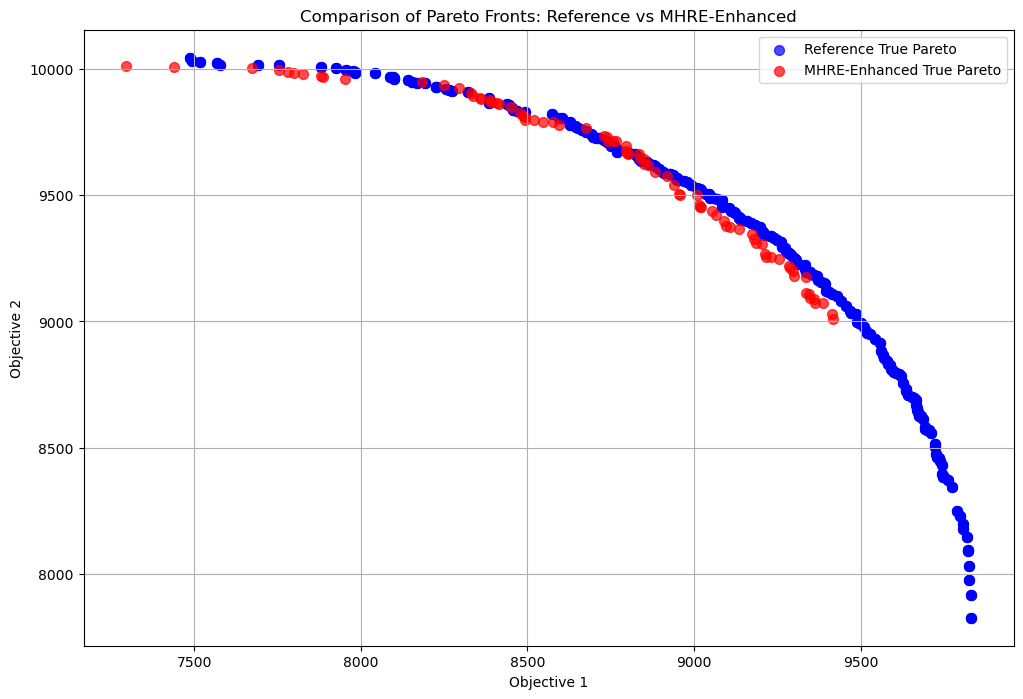


=== PERFORMANCE COMPARISON ===
Reference Pareto Front Hypervolume: -124044.92
MHRE-Enhanced Pareto Front Hypervolume: 907185.48
Improvement: -831.34%


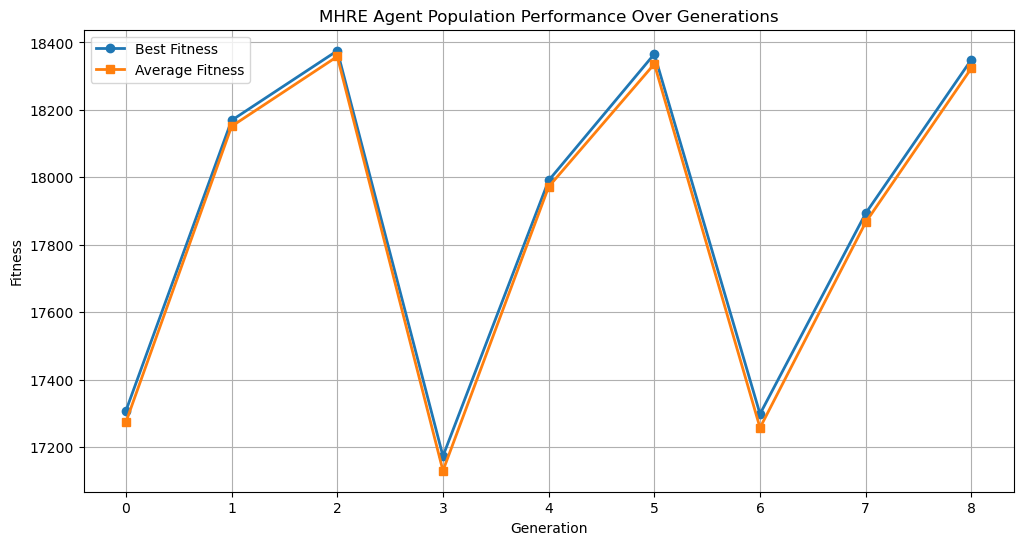

NameError: name 'move_stats' is not defined

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def load_pareto_front(filename):
    """Load Pareto front from file."""
    points = []
    with open(filename) as f:
        for line in f:
            line = line.strip()
            if line:
                points.append([float(x) for x in line.split()])
    return np.array(points)

def is_dominated(point, others):
    """Check if a point is dominated by any other point."""
    return np.any(np.all(others >= point, axis=1) & np.any(others > point, axis=1))

def get_pareto_front(points):
    """Extract the Pareto front from a set of points."""
    mask = np.ones(len(points), dtype=bool)
    for i, p in enumerate(points):
        others = np.delete(points, i, axis=0)
        if is_dominated(p, others):
            mask[i] = False
    return points[mask]

def hypervolume(points, reference_point):
    """Calculate hypervolume indicator."""
    sorted_points = sorted(points, key=lambda x: x[0])
    volume = 0.0
    prev_x = reference_point[0]
    for point in sorted_points:
        width = prev_x - point[0]
        height = reference_point[1] - point[1]
        volume += width * height
        prev_x = point[0]
    return volume

# Load and compare results
print("Loading and comparing results...")
ref_points = load_pareto_front("2502_Resulats.txt")
new_points = load_pareto_front("mhre_enhanced_results.txt")

# Get Pareto fronts
ref_pareto = get_pareto_front(ref_points)
new_pareto = get_pareto_front(new_points)

# Plot comparison
plt.figure(figsize=(12, 8))
plt.scatter(ref_pareto[:,0], ref_pareto[:,1], label="Reference True Pareto", alpha=0.7, color='blue', s=50)
plt.scatter(new_pareto[:,0], new_pareto[:,1], label="MHRE-Enhanced True Pareto", alpha=0.7, color='red', s=50)
plt.xlabel("Objective 1")
plt.ylabel("Objective 2")
plt.legend()
plt.title("Comparison of Pareto Fronts: Reference vs MHRE-Enhanced")
plt.grid(True)
plt.show()

# Calculate hypervolume improvement
ref_point = np.max(np.vstack([ref_pareto, new_pareto]), axis=0) * 1.1
ref_hv = hypervolume(ref_pareto, ref_point)
new_hv = hypervolume(new_pareto, ref_point)

print(f"\n=== PERFORMANCE COMPARISON ===")
print(f"Reference Pareto Front Hypervolume: {ref_hv:.2f}")
print(f"MHRE-Enhanced Pareto Front Hypervolume: {new_hv:.2f}")
print(f"Improvement: {(new_hv - ref_hv) / ref_hv * 100:.2f}%")

# Plot agent performance over generations
if hasattr(agent_manager, 'performance_history') and agent_manager.performance_history:
    generations = [p['generation'] for p in agent_manager.performance_history]
    best_fitness = [p['best_fitness'] for p in agent_manager.performance_history]
    avg_fitness = [p['avg_fitness'] for p in agent_manager.performance_history]
    
    plt.figure(figsize=(12, 6))
    plt.plot(generations, best_fitness, label='Best Fitness', marker='o', linewidth=2)
    plt.plot(generations, avg_fitness, label='Average Fitness', marker='s', linewidth=2)
    plt.xlabel('Generation')
    plt.ylabel('Fitness')
    plt.title('MHRE Agent Population Performance Over Generations')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot move type distribution
if move_stats and 'move_type_counts' in move_stats:
    move_types = list(move_stats['move_type_counts'].keys())
    counts = list(move_stats['move_type_counts'].values())
    
    plt.figure(figsize=(12, 6))
    plt.bar(move_types, counts)
    plt.xlabel('Move Type')
    plt.ylabel('Usage Count')
    plt.title('Move Type Distribution in MHRE')
    plt.xticks(rotation=45)
    plt.grid(True, axis='y')
    plt.show()

print("\nMHRE implementation completed successfully!")

In [15]:
!pip install scikit-learn


[notice] A new release of pip is available: 25.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
A:\conda\envs\ibmols\python.exe

In [37]:
import sys
print(sys.executable)

A:\conda\envs\ibmols\python.exe


In [5]:
import sklearn
print(sklearn.__file__)

A:\conda\envs\ibmols\lib\site-packages\sklearn\__init__.py


In [5]:
import numpy, scipy, sklearn
print(numpy.__version__, scipy.__version__, sklearn.__version__)

1.26.4 1.13.1 1.6.1


In [6]:
import requests
resp = requests.post("http://localhost:11434/api/generate", json={"model": "llama3", "prompt": "def f(): return 1", "stream": False})
print(resp.json())

{'model': 'llama3', 'created_at': '2025-09-06T17:51:18.9589415Z', 'response': "A nice simple one!\n\nThe function `f` is defined as:\n```\ndef f(): return 1\n```\nThis is a function that takes no arguments and returns the value `1`.\n\nYou can call this function like any other:\n```\nresult = f()\nprint(result)  # Output: 1\n```\nNote that there's no parameter list (`()`), which means the function doesn't take any arguments. The `return` statement specifies what value is returned when the function is called. In this case, it's always `1`.", 'done': True, 'done_reason': 'stop', 'context': [128006, 882, 128007, 271, 755, 282, 4658, 471, 220, 16, 128009, 128006, 78191, 128007, 271, 32, 6555, 4382, 832, 2268, 791, 734, 1595, 69, 63, 374, 4613, 439, 512, 14196, 4077, 755, 282, 4658, 471, 220, 16, 198, 14196, 4077, 2028, 374, 264, 734, 430, 5097, 912, 6105, 323, 4780, 279, 907, 1595, 16, 63438, 2675, 649, 1650, 420, 734, 1093, 904, 1023, 512, 14196, 4077, 1407, 284, 282, 746, 1374, 4556, 8, 